In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, \
forecast_by_week, train_test_split,update_deepAR_parameters, \
generate_model_results_by_hp_dict
from PythonFiles.PlottingFunctions import plot_coverage, print_forecasts_by_week, hyperparameter_boxplots, plot_model_results_by_hp, hp_color_plot
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from ray import tune
config = Configuration()

In [2]:
df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/FNN_Hyperparameter_results_15_05.csv", sep=',')

print(len(df))
hp_search_space = {
    "num_hidden_dimensions": tune.grid_search([[5],[10], [20]]),
    "context_length":tune.grid_search([4, 52, 104]),
    "epochs":tune.grid_search([5, 10, 20]),
    "prediction_length" : tune.grid_search([4, 52, 104]), 
    "num_batches_per_epoch":tune.grid_search([25, 50, 100]),
    "batch_normalization":tune.grid_search([True, False]),
    "batch_size":tune.grid_search([20, 32, 64]),
    }

model_results_by_hp, overall_df = generate_model_results_by_hp_dict(df, hp_search_space)

3751
There are combinations with fewer modelRuns!!
                           total_modelruns  independent_combinations
modelruns_per_combination                                           
3.0                                   1944                     648.0
2.0                                   1434                     717.0
4.0                                    368                      92.0
5.0                                      5                       1.0


In [3]:
def update_FNN_parameters(config, new_parameters):
    ''' 
    This function updates the DeepAR-configuration in the Configuration.py file. 
    Note that new_parameters must be a dict containing the exact keys used in config.parameters.
    '''
    parameters = config.fnnparameters.copy()
    for key in new_parameters.keys():
        if key in parameters.keys():
            parameters[key] = new_parameters[key]
        else:
            print(f"This key {key} isn't available in config.parameters! Thus the default config will maintain.")

    fnnestimator = SimpleFeedForwardEstimator(num_hidden_dimensions=parameters["num_hidden_dimensions"],
                                              prediction_length=parameters["prediction_length"],
                                              context_length=parameters["context_length"],
                                              distr_output=parameters["distr_output"],
                                              batch_size=parameters["batch_size"],
                                              batch_normalization=parameters["batch_normalization"],
                                              trainer=Trainer(epochs=parameters["epochs"],
                                                              num_batches_per_epoch=parameters["num_batches_per_epoch"],
                                                             ),
                                              )
    return fnnestimator

def evaluate(config, train, test, configuration):
    
    fnnestimator = update_FNN_parameters(configuration, config)
    
    predictor = fnnestimator.train(train)
    
    forecast_it, ts_it = make_evaluation_predictions(dataset=test, predictor=predictor,num_samples=100)
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    # Evaluation with the quantiles of the configuration and calculation of the mean_WIS
    evaluator = Evaluator(quantiles=configuration.quantiles)    
    agg_metrics = evaluator(tss, forecasts)[0]
    mean_WIS = agg_metrics["mean_absolute_QuantileLoss"]/(config["prediction_length"]*411)
    return mean_WIS

def objectiveFNN(config, train, test, configuration):
    score = evaluate(config, train, test, configuration)
    session.report({"mean_WIS":score})

In [4]:
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')
population_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/PopulationVector.csv", sep=',')
neighbourhood_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/AdjacentMatrix.csv", sep=',', index_col=0)

config.train_start_time = datetime(1999,1,1,0,0,0)#datetime(2010,1,1,0,0,0)
config.train_end_time = datetime(2016,9,30,23,0,0)
config.test_end_time = datetime(2018,9,30,23,0,0)
overall_evaluation_df = pd.DataFrame()

data_splits_dict = {}
output_dict = {}

locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date','week']]
df = preprocessing(config, df, check_count=False, output_type="corrected_df")
for location in locations:
    df.loc[df.location == location, "population"] = int(population_df.loc[population_df.Location == location, "2011"].values[0])
    df.loc[df.location == location, locations] = neighbourhood_df.loc[neighbourhood_df.index==location,locations].values[0].astype(int)
    
# Data split with no additional features and training start in 2010
#data_splits_dict["without_features_2001"] = list(train_test_split(config, df, False))
data_splits_dict["with_features_2001"] = list(train_test_split(config, df, True))

# Change the beginning of the training period
#config.train_start_time = datetime(2010,1,1,0,0,0)
#data_splits_dict["without_features_2010"] = list(train_test_split(config, df, False))
#data_splits_dict["with_features_2010"] = list(train_test_split(config, df, True))


train = data_splits_dict["with_features_2001"][0]
test = data_splits_dict["with_features_2001"][1]
configuration = Configuration()

In [8]:
from PythonFiles.model import restore_HP_results
experiment_path = f"/home/reffert/ray_results/objectiveFNN_2023-05-15_08-37-46"
import ray
ray.shutdown()
results_df = restore_HP_results(experiment_path, objectiveFNN, train, test, configuration)

Loading results from /home/reffert/ray_results/objectiveFNN_2023-05-15_08-37-46...


2023-05-19 11:53:25,873	INFO worker.py:1553 -- Started a local Ray instance.
2023-05-19 11:53:47,445	WARNING tuner_internal.py:292 -- The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
2023-05-19 11:53:47,943	INFO experiment_analysis.py:789 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


In [9]:
print(len(results_df))

3751


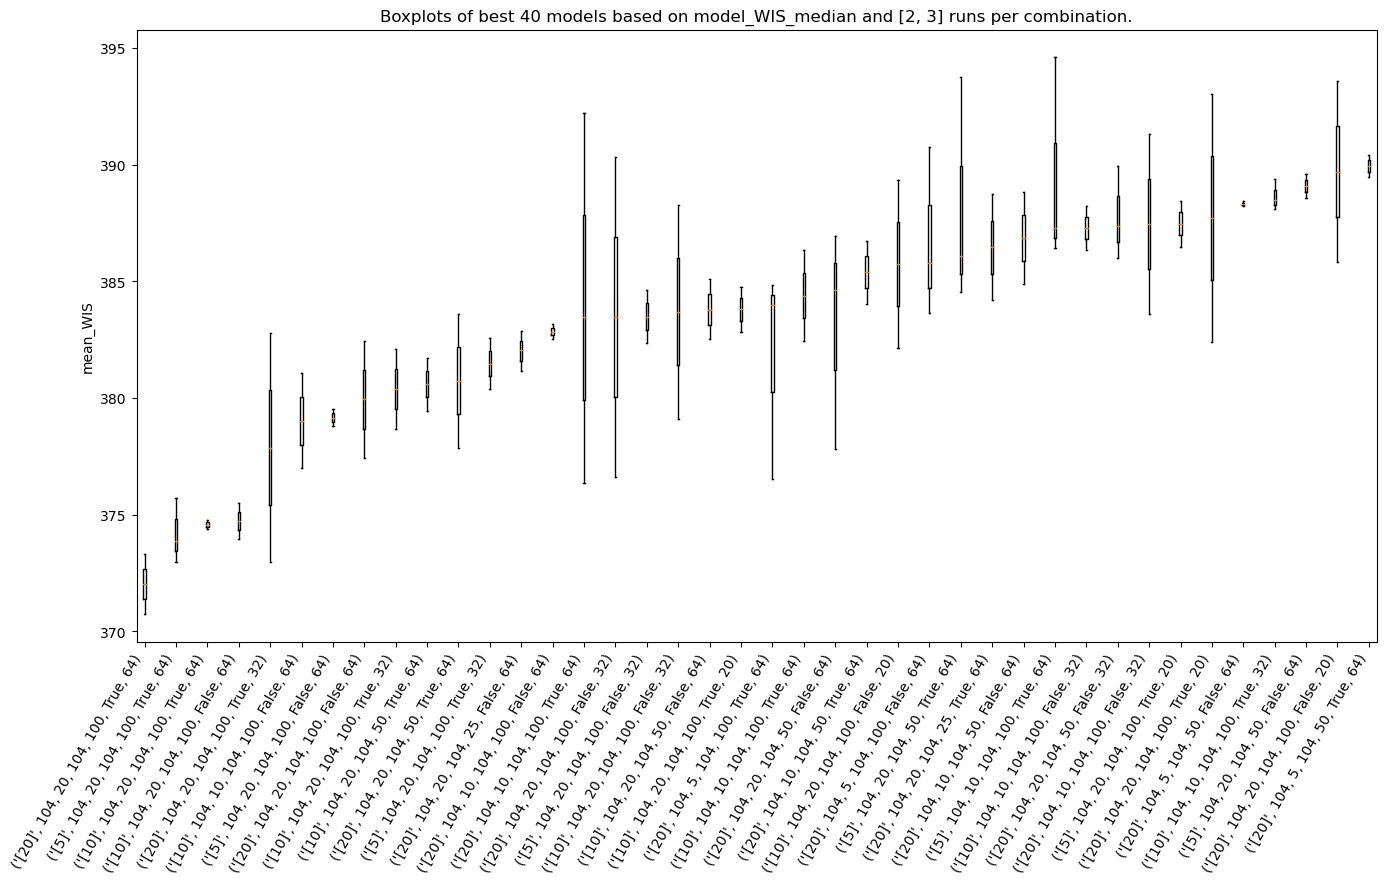

In [3]:
plot_model_results_by_hp(config, model_results_by_hp, hp_search_space, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df, sort_by="model_WIS_median", plottype="best", plot = "bp")

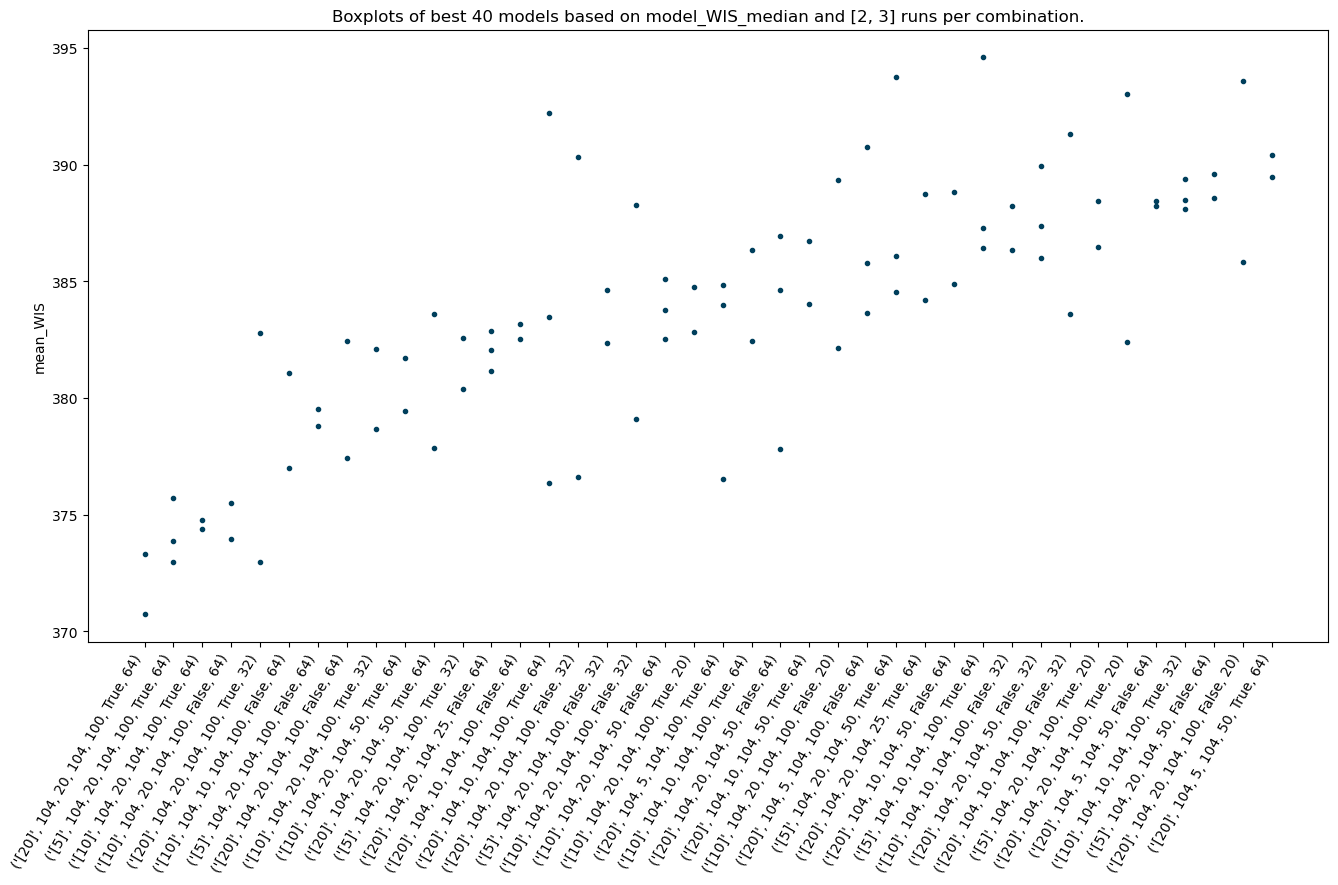

In [4]:

'''
col: "mean_WIS", "time_this_iter_s"
sort_by: "mean_WIS", "time_this_iter_s", "model_WIS_mean", "model_WIS_variance", "model_WIS_sd", "model_WIS_median", "model_time_mean", "model_time_variance", "model_time_sd",\
         "model_time_median"(, "shape") 
plottype: "unordered"(not ordered), "best" or "worst"
'''
plot_model_results_by_hp(config, model_results_by_hp, hp_search_space, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df, sort_by="model_WIS_median", plottype="best", plot = "scatter")

In [5]:
added_cols = ["model_WIS_mean", "model_WIS_variance", "model_WIS_sd", "model_WIS_median", "model_time_mean", "model_time_variance", "model_time_sd",\
         "model_time_median", "shape"] 
display(overall_df.sort_values("model_WIS_mean")[added_cols+[col for col in df.columns if ("config" in col)&("cardinality" not in col)]].drop_duplicates().head(20))

,model_WIS_mean,model_WIS_variance,model_WIS_sd,model_WIS_median,model_time_mean,model_time_variance,model_time_sd,model_time_median,shape,config/batch_normalization,config/batch_size,config/context_length,config/epochs,config/num_batches_per_epoch,config/num_hidden_dimensions,config/prediction_length
2913,372.027312,3.247982,1.802216,372.027312,2856.898168,408.078828,20.200961,2856.898168,2.0,True,64,104,20,100,[20],104
2590,374.194775,1.925085,1.387474,373.886279,2802.324733,19029.267698,137.946612,2728.541998,3.0,True,64,104,20,100,[5],104
1294,374.582582,0.081646,0.285738,374.582582,3103.098679,292064.767537,540.430169,3103.098679,2.0,True,64,104,20,100,[10],104
1295,374.736024,1.171124,1.082185,374.736024,3074.330297,226220.233263,475.626149,3074.330297,2.0,False,64,104,20,100,[10],104
2911,377.880951,48.088977,6.934622,377.880951,1401.677297,1654.682333,40.677787,1401.677297,2.0,True,32,104,20,100,[20],104
2735,379.027664,8.297040,2.880458,379.027664,1503.350855,52520.871381,229.174325,1503.350855,2.0,False,64,104,10,100,[10],104
1133,379.166168,0.250068,0.500068,379.166168,2760.604853,205.245146,14.326379,2760.604853,2.0,False,64,104,20,100,[5],104
2914,379.942851,12.528903,3.539619,379.942851,2907.197712,76.640643,8.754464,2907.197712,2.0,False,64,104,20,100,[20],104
1292,380.372396,5.864037,2.421577,380.372396,1560.699778,71481.293464,267.359858,1560.699778,2.0,True,32,104,20,100,[10],104
1240,380.603026,2.578923,1.605902,380.603026,1411.546508,326.894324,18.080219,1411.546508,2.0,True,64,104,20,50,[10],104


1458
3751


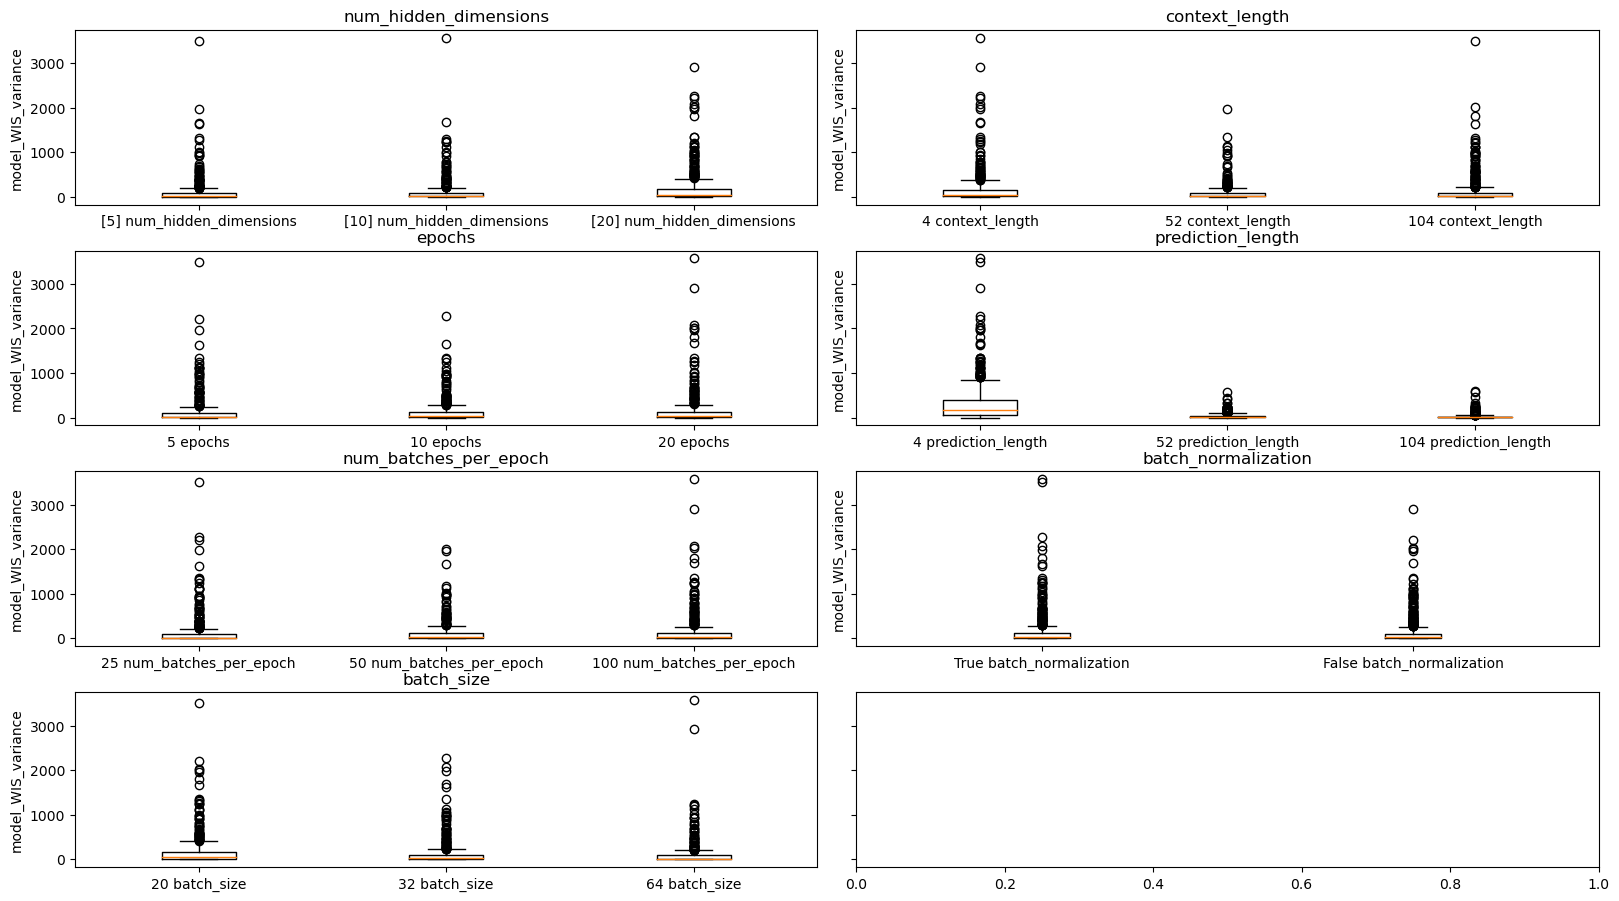

________________


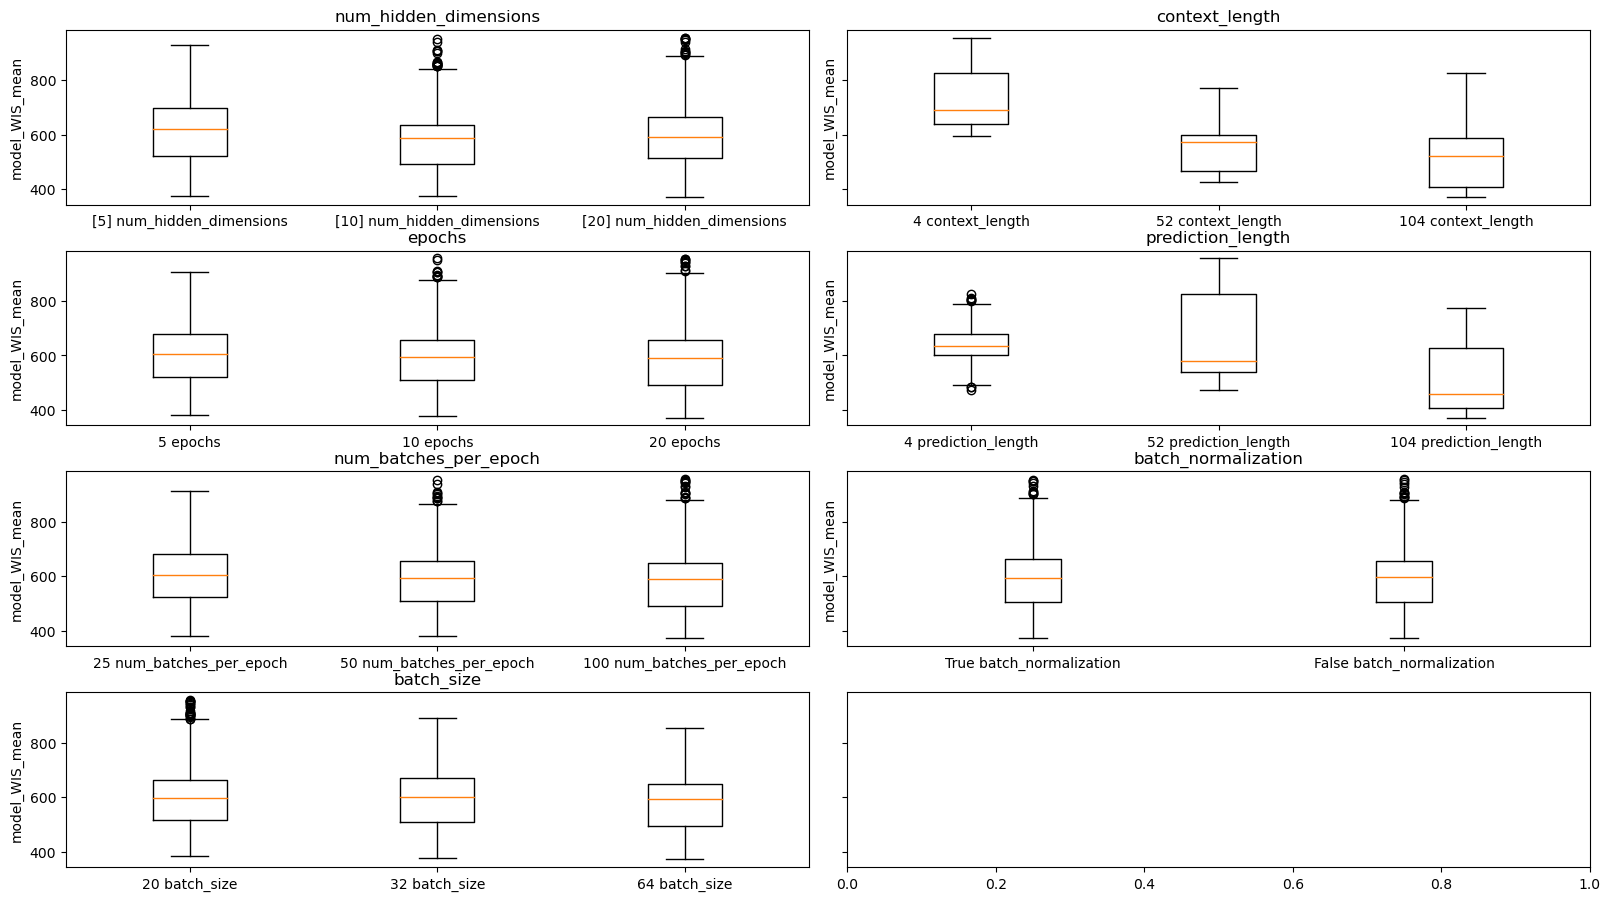

In [6]:
unique_df = overall_df[added_cols+[col for col in df.columns if ("config" in col)&("cardinality" not in col)]].drop_duplicates()
print(len(unique_df))
print(len(overall_df))
hyperparameter_boxplots(unique_df, hp_search_space, col="model_WIS_variance")
print("________________")
hyperparameter_boxplots(unique_df, hp_search_space, col="model_WIS_mean")

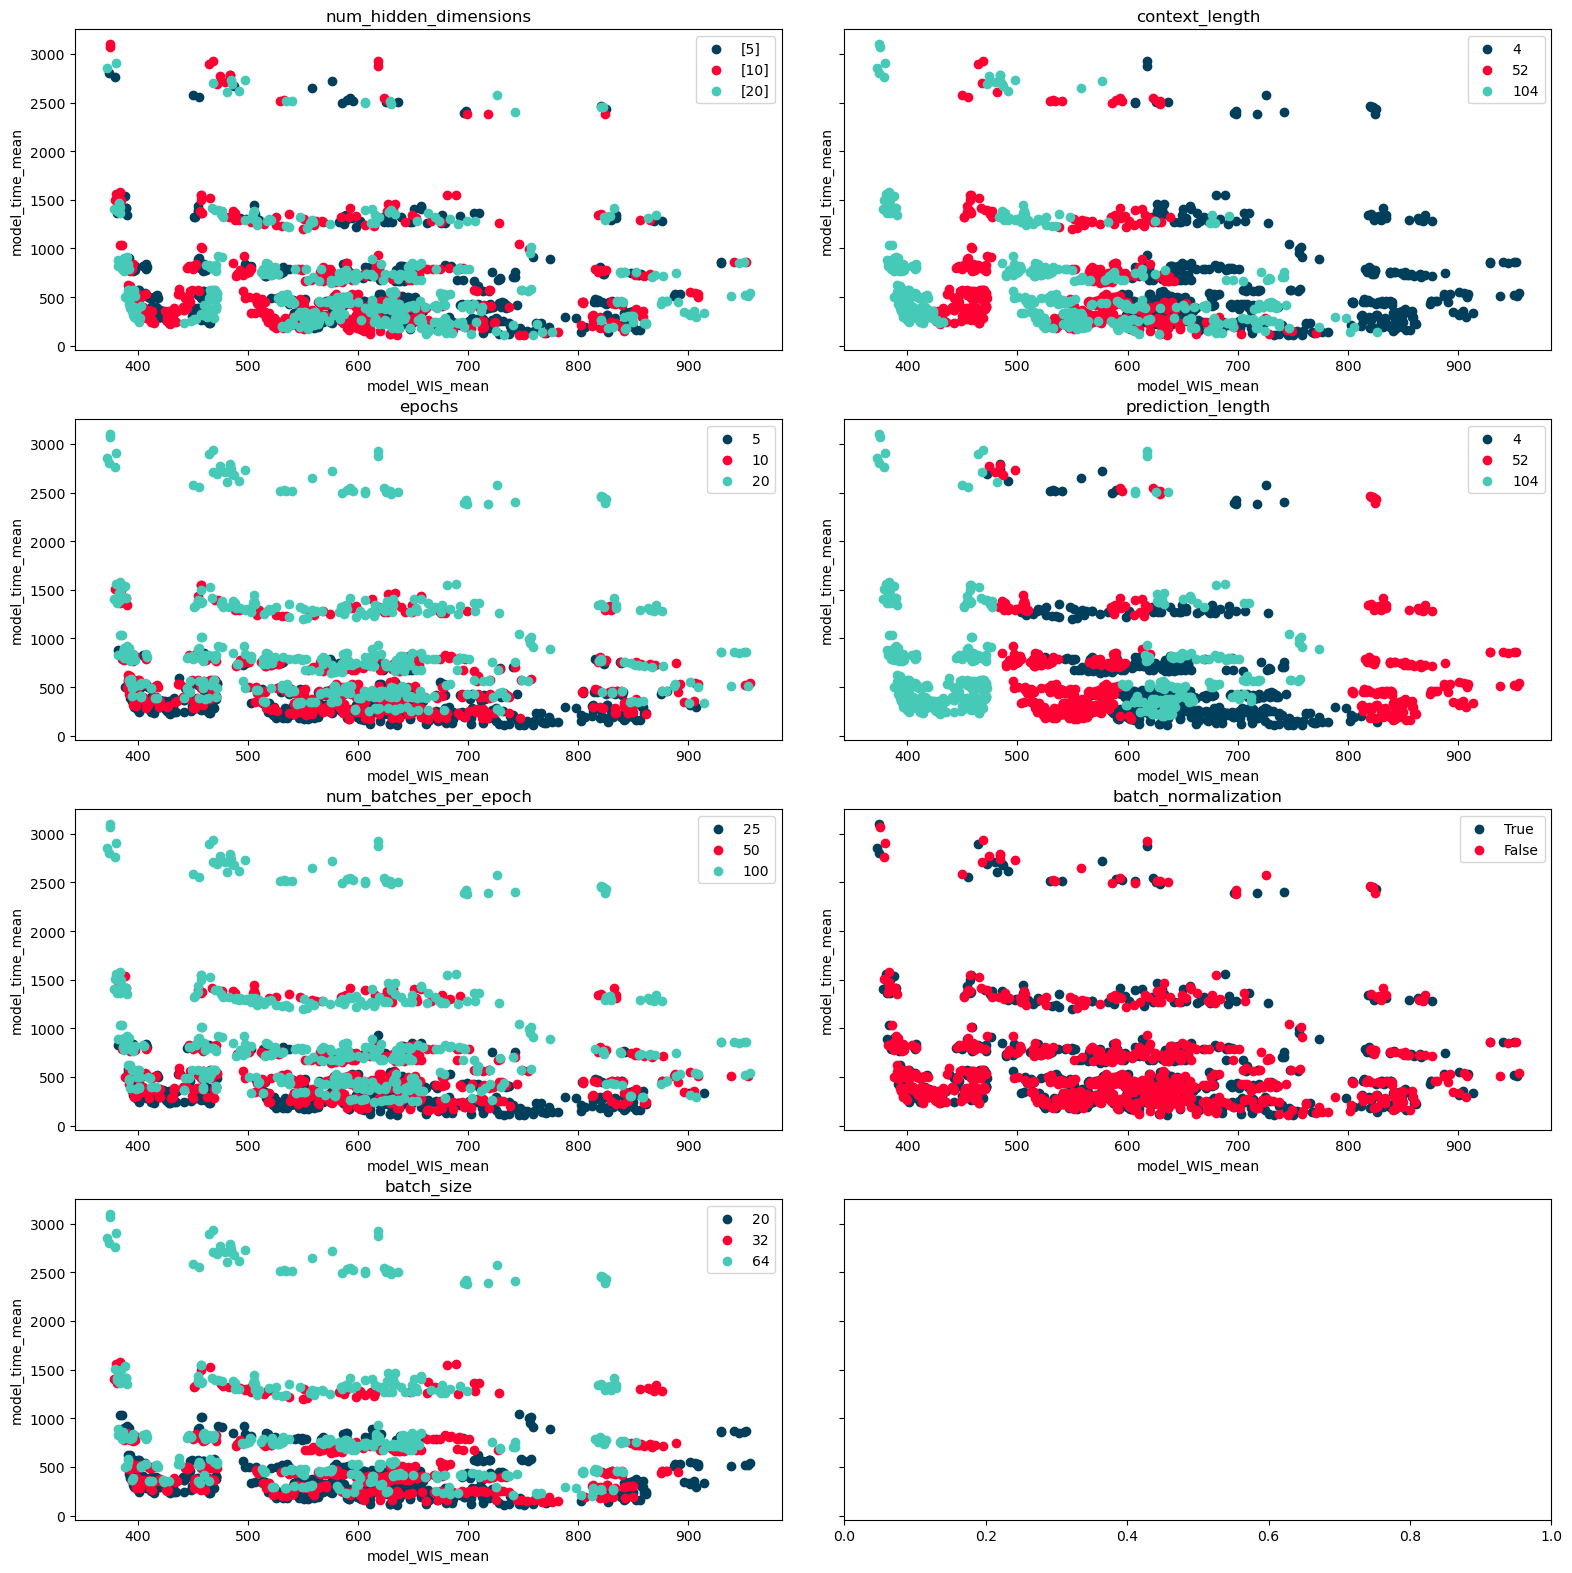

In [7]:
hp_color_plot(config, overall_df, hp_search_space, )

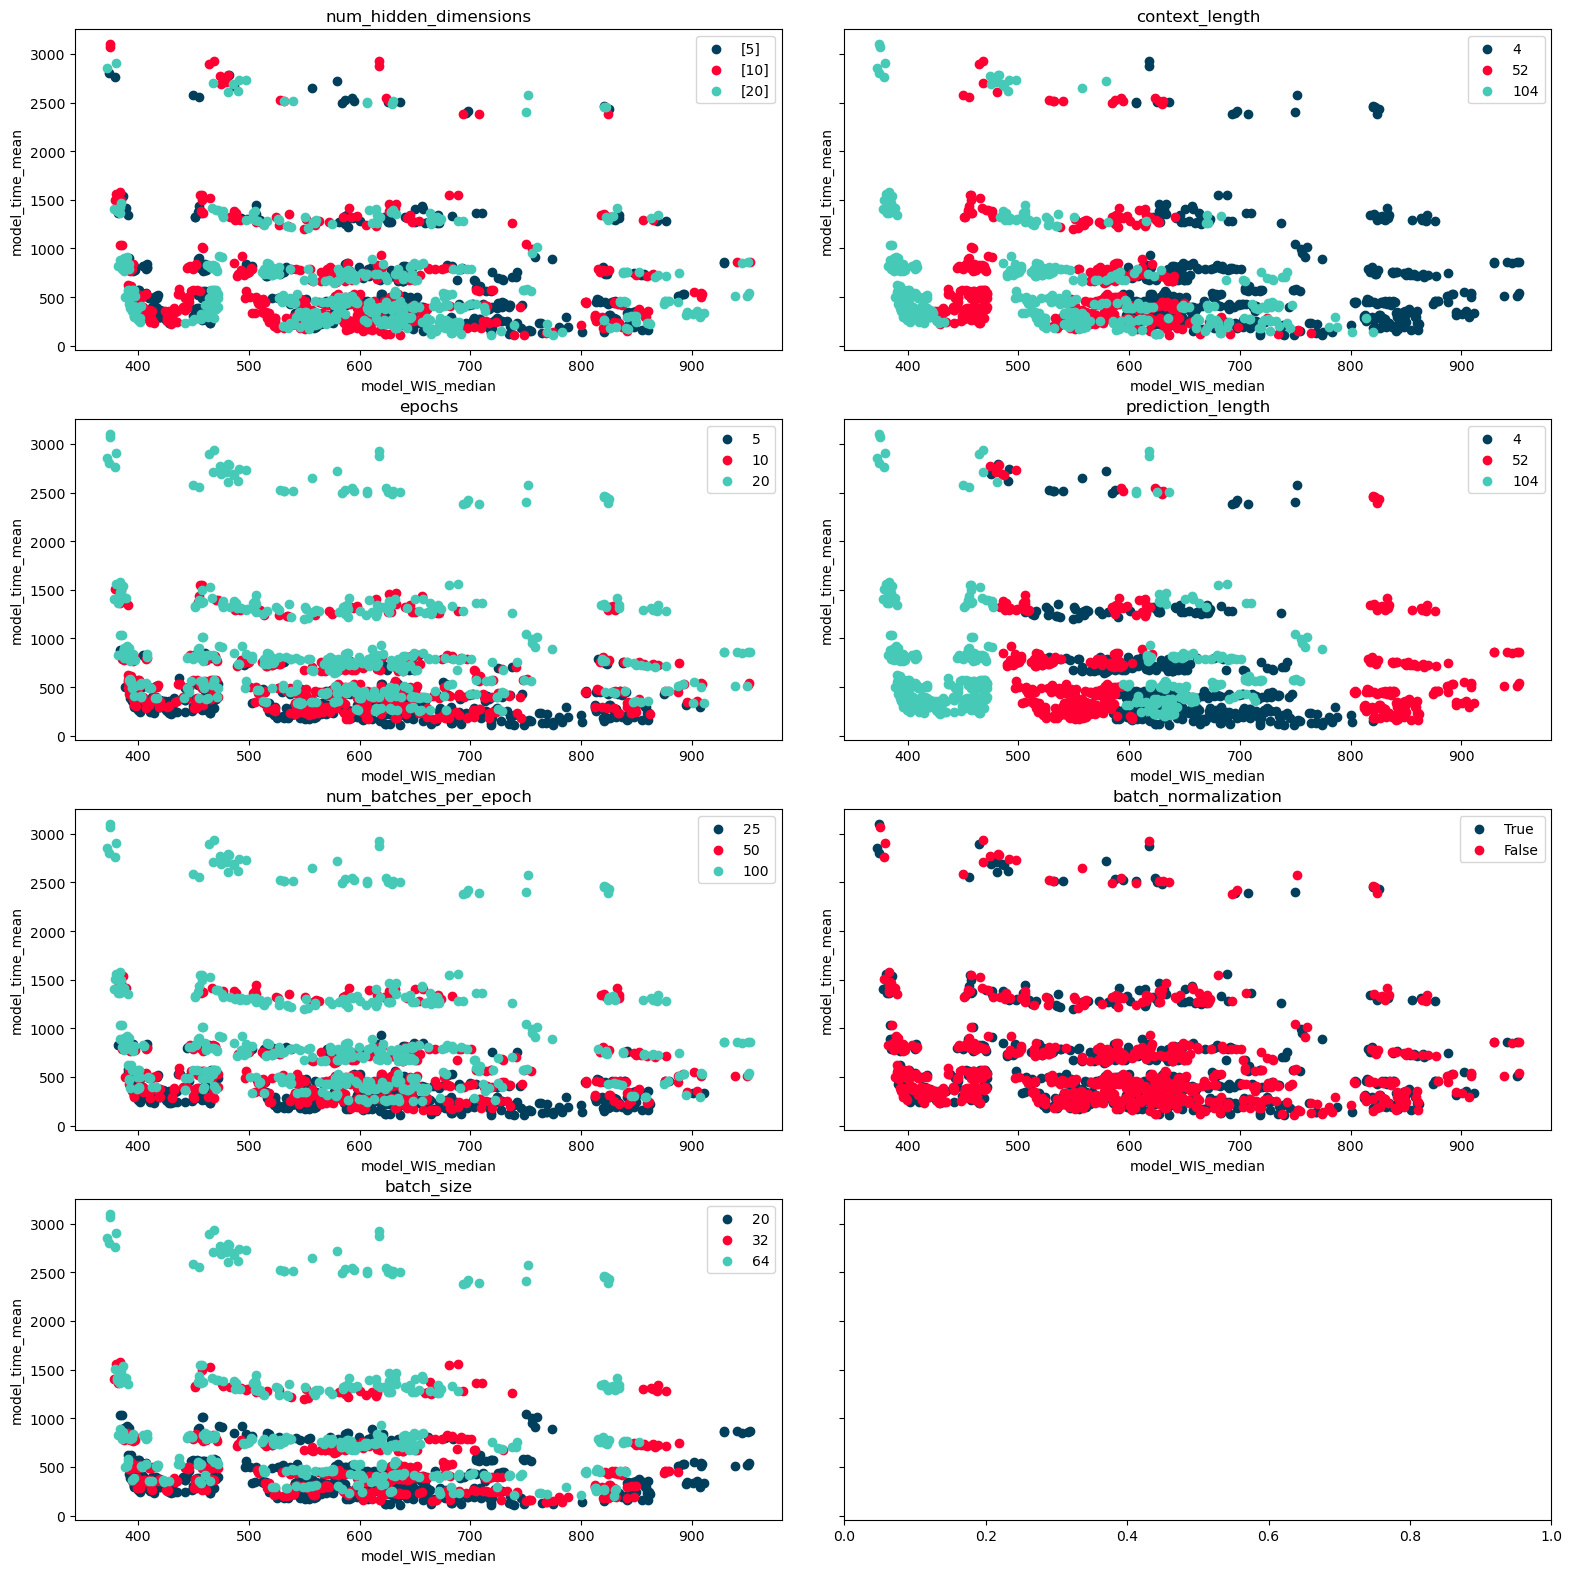

In [8]:
hp_color_plot(config, overall_df, hp_search_space, x_axis="model_WIS_median", y_axis="model_time_mean")